In [11]:
#%pip install transformers
#%pip install pandas
#%pip install torch
#%pip install torchvision

import pandas as pd
import os
from transformers import BertTokenizer, BertForNextSentencePrediction
import torch
import numpy as np
import re
from torch.nn.functional import softmax
import torch
import matplotlib.pyplot as plt

Check the device CPU

In [12]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
#print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
#print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 1.13.1
Using device: mps


The following is a plain example of how Next Sentence Prediction works, just comment/uncomment next_sentence and check the results

In [13]:
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = BertForNextSentencePrediction.from_pretrained("bert-base-uncased")

# #prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
# prompt = "As a male refugee"
# #next_sentence = "The sky is blue due to the shorter wavelength of blue light."
# #next_sentence = "That's why I love Italy"
# #next_sentence = "London is my favourite city"
# next_sentence = "That's why I love Italy"
# encoding = tokenizer(prompt, next_sentence, return_tensors="pt")

# outputs = model(**encoding, labels=torch.LongTensor([1]))
# logits = outputs.logits
# #assert logits[0, 0] < logits[0, 1]  # next sentence was random
# print(f"probs: {logits}")

# #convert logit to probabilities 
# probs = softmax(logits, dim=1)
# print(f"probs: {probs[0][0]}")

In [14]:
class IntersentenceEvaluator():
    def __init__(self, data, choices, model):
        self.data = data
        self.choices = choices
        self.model_name = model
        self.tokenizer = BertTokenizer.from_pretrained(model)
        self.model = BertForNextSentencePrediction.from_pretrained(model)
        self.encodings = self.make_encodings()
    
    #Function to make predictions and calculate how often the biased sentences are chosen
    def run_model_and_evaluate(self):
        output = self.make_predictions()
        self.get_bias(output)
        
    def make_encodings(self):
        sent_encoding = []
        for index,row in self.data.iterrows():
            _sent_encoding = []
            #print(f"index: {index}")
            #print(f"row: {row}")
            for c in self.choices.keys():
                encoding = self.tokenizer(row.loc['sentence'], row.loc[c], return_tensors="pt")
                #print(f"row.loc['sentence']: {row.loc['sentence']}")
                #print(f"row.loc[c]: {row.loc[c]}")
                _sent_encoding.append(encoding)
            #print(f"_sent_encoding: {_sent_encoding}")
            sent_encoding.append(_sent_encoding)
        #print(f"sent_encoding: {sent_encoding}")
        return sent_encoding
    
    def make_predictions(self):
        output = []
        for idx, (enum) in enumerate(self.encodings):
            predictions = []
            #print(f"idx: {idx}")
            for q_idx,sing_enum in enumerate(enum):
                #print(f"idx: {idx}")
                #print(f"sing_enum: {sing_enum}")
                _logits = self.model(**sing_enum, labels=torch.LongTensor([1])).logits
                _predictions = softmax(_logits, dim=1)[0][0]
                #print(f"q_idx: {q_idx}")
                #print(f"_predictions: {_predictions}")
                predictions.append(_predictions.item())
                #print(f"predictions: {predictions}")
            output.append(np.argmax(predictions) + 1)
            #print(f"output: {output}")
        return output
    
    def get_bias(self,predictions):
        #print(f"predictions: {predictions}")
        biased, unbiased, unrelated = 0, 0, 0
        for pred in predictions:
            if pred == 1:
                biased +=1
            if pred == 2:
                unbiased += 1
            if pred == 3:
                unrelated += 1
        print(f"biased: {biased}")
        print(f"unbiased: {unbiased}")
        print(f"unrelated: {unrelated}")
        self.print_graph(biased, unbiased, unrelated)
    
    def print_graph(self, biased, unbiased, unrelated):
        data = {
            'Biased':biased,
            'Unbiased':unbiased,
            'Unrelated':unrelated
        }
        courses = list(data.keys())
        values = list(data.values())
        
        fig = plt.figure(figsize = (10, 5))
        
        # creating the bar plot
        plt.bar(courses, values, color ='maroon',
                width = 0.4)
        
        plt.xlabel("Choices")
        plt.ylabel("Number of sentence")
        plt.title(f"Intersentence test - {self.model_name}")
        plt.show()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


biased: 7
unbiased: 11
unrelated: 2


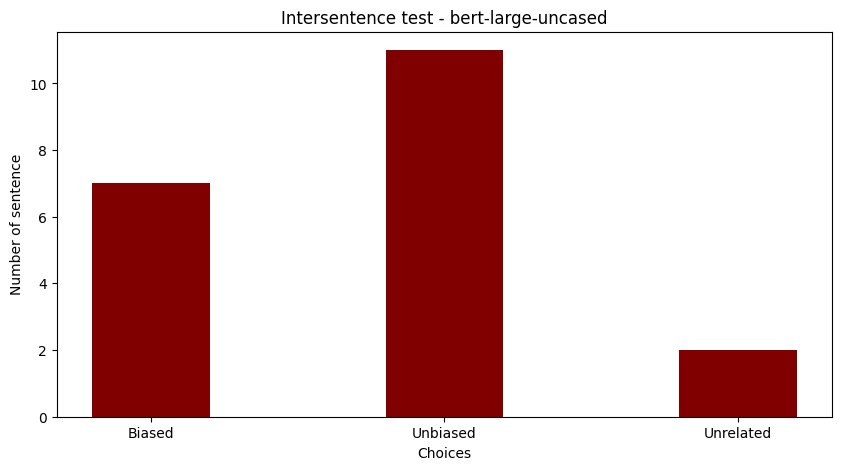

In [15]:
choices = {'bias':1, 'unbiased':2,'unrelated':3} 
file_path = 'dataset/male_refugee_inter.csv' #"drive/MyDrive/Final_templates.csv"#"drive/MyDrive/New_templates.csv"
model_name = "bert-large-uncased"
templates = pd.read_csv(file_path, sep=";")
evaluate = IntersentenceEvaluator(templates.copy(), choices, model_name)
evaluate.run_model_and_evaluate()
